In [1]:
import numpy as np
from scipy.spatial.distance import euclidean
import scipy
import torch

import dtw
import dtwalign
from fastdtw import fastdtw

from sklearn.manifold import TSNE
import pandas as pd

from src.speech_classification.audio_processing import SpeechCommandsDataCollector, AudioPreprocessorMFCCDeltaDelta
from src.siamese_net_sound_similarity.slstm_train import SiameseSpeechCommandsDataCollector
from src.siamese_net_sound_similarity.train_v2_with_settle_structure import SiameseDeepLSTMNet
from src.siamese_net_sound_similarity.train import SiameseLSTMNet

from src.siamese_net_sound_similarity.soft_dtw import SoftDTW

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set(font_scale=1.4, rc={'text.usetex' : False})
sns.set_style("whitegrid")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import yaml
from pprint import pprint

# %matplotlib inline

## Load data

In [2]:
DISTANCE='euclidean'
STEP_PATTERN = 'typeIc'
CLOSED_END_STEP_PATTERN = "typeIc"
# DISTANCE=lambda x, y : minkowski(x,y, 1)

In [3]:
config_path = r'C:\Study\SpeechAcquisitionModel\reports\seamise_net_01_09_2020_05_52_PM\config.yaml'
with open(config_path, 'r') as data_file:
    config = yaml.safe_load(data_file)
pprint(config)

# wanted_words = config['wanted_words']
wanted_words = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left']



wanted_words_combined = wanted_words

model_settings = config
query_length = 100

{'batch_norm': True,
 'dct_coefficient_count': 13,
 'dist': 'l1',
 'dropout': 0.3,
 'hidden_fc': [1024, 1024, 1024],
 'hidden_reccurent': [512, 512, 512],
 'label_count': 32,
 'learning_rate': 0.0005,
 'loss_type': 'sdtw',
 'margin': 0.4,
 'mfcc_num': 39,
 'mini_batch_size': 64,
 'open_end': False,
 'save_dir': "r'C:\\Study\\SpeechAcquisitionModel\\models\\siamese_net_sound_similarity'",
 'train_steps': 100000,
 'triplet_anneal_b': 1500,
 'triplet_anneal_k': 0.0025,
 'wanted_words': ['bed',
                  'bird',
                  'cat',
                  'dog',
                  'down',
                  'eight',
                  'five',
                  'four',
                  'go',
                  'happy',
                  'house',
                  'left',
                  'marvin',
                  'nine',
                  'no',
                  'off',
                  'on',
                  'one',
                  'right',
                  'seven',
             

In [4]:
preproc = AudioPreprocessorMFCCDeltaDelta(numcep=model_settings['dct_coefficient_count'], winlen=model_settings['winlen'],
                                     winstep=model_settings['winstep'])

data_iter = SiameseSpeechCommandsDataCollector(preproc,
                                        data_dir=r'C:\Study\Speech_command_classification\speech_dataset',
                                        wanted_words=wanted_words_combined,
                                        testing_percentage=10,
                                        validation_percentage=10
                                        )

index_to_word = {v:k for k,v in data_iter.word_to_index.items()}

# Gather Data for analysis

In [5]:
n_mini_batch_size = 2000

# gather data


data = data_iter.get_data(n_mini_batch_size, 0, 'training')
labels = data['y']

duplicates = data_iter.get_duplicates(labels, 0, 'training')
assert np.any(labels == duplicates['y'])

non_duplicates = data_iter.get_nonduplicates(labels, 0, 'training')
assert np.any(labels != non_duplicates['y'])


In [27]:
# load nn

# nn_fname = r'C:\Study\SpeechAcquisitionModel\reports\seamise_net_01_17_2020_08_47_PM\net_44000_0.0546875.net'
nn_fname = r'C:\Study\SpeechAcquisitionModel\reports\seamise_net_01_22_2020_12_57_PM\net_49500_0.01953125.net'


nn = torch.load(nn_fname)

In [28]:
nn_input = torch.from_numpy(data['x']).cuda().float()

In [29]:
z, *_ = nn.single_forward(nn_input)
z = z.detach().cpu().numpy()

duplicates_z, *_ = nn.single_forward(torch.from_numpy(duplicates['x']).cuda().float())
duplicates_z = duplicates_z.detach().cpu().numpy()

non_duplicates_z, *_ = nn.single_forward(torch.from_numpy(non_duplicates['x']).cuda().float())
non_duplicates_z = non_duplicates_z.detach().cpu().numpy()

## Visuialize embedding space with t-SNE

### Whole sequence (visualize trajectories in the embedding space)

In [30]:
# whole_dataset = np.concatenate([z, duplicates_z, non_duplicates_z])
whole_dataset = z
whole_dataset = whole_dataset[:, -1:, :]

# whole_dataset_flatten = whole_dataset.reshape(whole_dataset.shape[0], -1)
whole_dataset_flatten = whole_dataset.reshape(-1, whole_dataset.shape[-1])

In [31]:
print(z.shape)

(2000, 99, 256)


In [32]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(whole_dataset_flatten)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.046s...
[t-SNE] Computed neighbors for 2000 samples in 1.540s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.086332
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.220596
[t-SNE] Error after 300 iterations: 0.886683


In [33]:
# seq_len = whole_dataset.shape[1]
# sizes = np.linspace(0.1, 1.0, seq_len)
# plt.figure(figsize=(16,16))

# for k in range(1000):
#       sns.lineplot(
#         x=tsne_results[k*seq_len:(k+1)*(seq_len), 0], y=tsne_results[k*seq_len:(k+1)*(seq_len), 1],
#         color=sns.color_palette("Paired", 50)[int(labels[k])],
# #         hue=sizes,
# #          palette=sns.color_palette("hls", 30),
        
#         legend="full",
#         alpha=0.3,
#         sort=False,

#     )
# # sns.lineplot(
# #     x="t-SNE 1 dim", y="t-SNE 2 dim",
# #     hue="y",
# # #     palette=sns.color_palette("hls", 10),
# #     data=df,
# #     legend="full",
# #     alpha=0.3,
# #     sort=False
# # )

In [34]:
word_labels = [index_to_word[l] for l in labels]
d = pd.DataFrame({'t-SNE 1st component': tsne_results[:,0],
                 't-SNE 2st component': tsne_results[:,1],
                 'word_indexes': labels,
                 'word': word_labels})


In [35]:
%matplotlib inline

(2000, 2)
(2000, 1, 256)


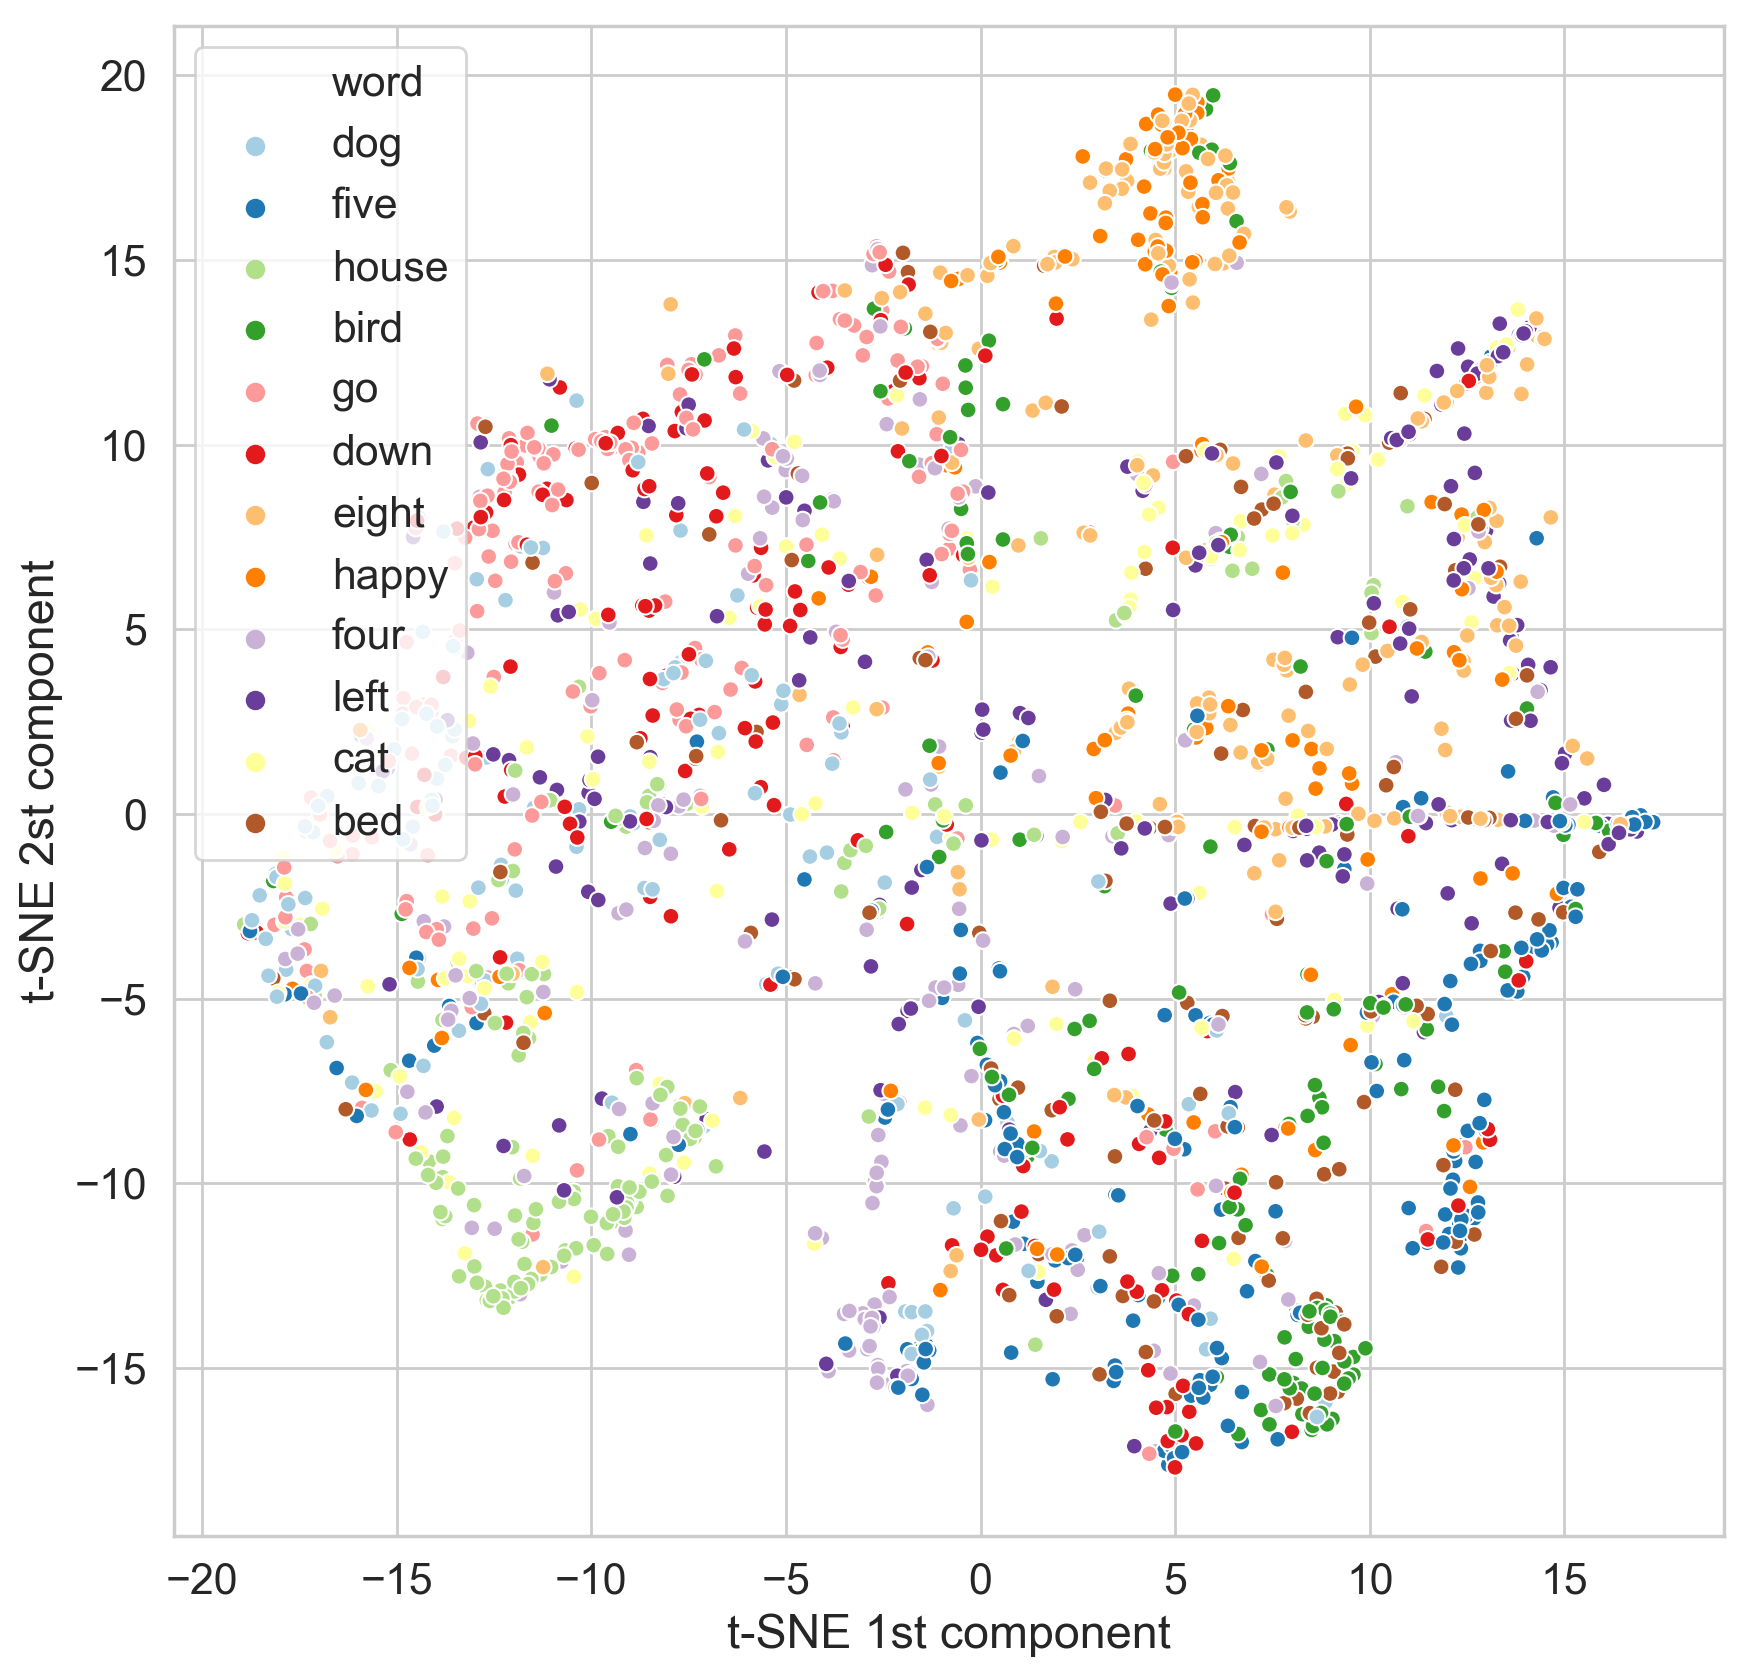

In [37]:
# %matplotlib notebook

seq_len = whole_dataset.shape[1]
sizes = np.linspace(0.1, 1.0, seq_len)
fig = plt.figure(figsize=(10,10), dpi=200)
ax = fig.add_subplot(111)
print(tsne_results.shape)
print(whole_dataset.shape)
# for k in range(100):
sns.scatterplot(
x='t-SNE 1st component',
y='t-SNE 2st component',
hue = 'word',
data=d,
palette=sns.color_palette("Paired", 12)
# color=sns.color_palette("Paired", 50)[int(labels[k])],
#         hue=sizes,
#          palette=sns.color_palette("hls", 30),



#         sort=False,

)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=1)